In [6]:
from glob import glob
from src import Module, DataModule, DatasetFCI
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import matplotlib.pyplot as plt

In [3]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/r18-fci-da-val_metric=0.64330-epoch=17.ckpt',
 './checkpoints/r18-fci-epoch=29.ckpt',
 './checkpoints/r18-fci-da-epoch=29.ckpt',
 './checkpoints/r18-fcim-val_metric=0.61680-epoch=4.ckpt',
 './checkpoints/r18-fcim-epoch=12.ckpt',
 './checkpoints/r18-fci-val_metric=0.65102-epoch=8.ckpt']

In [4]:
name = "r18-fci-da-val_metric=0.64330-epoch=17.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module({"encoder": "resnet18", "in_chans": 5, "pretrained": None, "padding": 1})
module.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
dm = DataModule(Dataset="DatasetFCI", batch_size=5)
dm.setup()

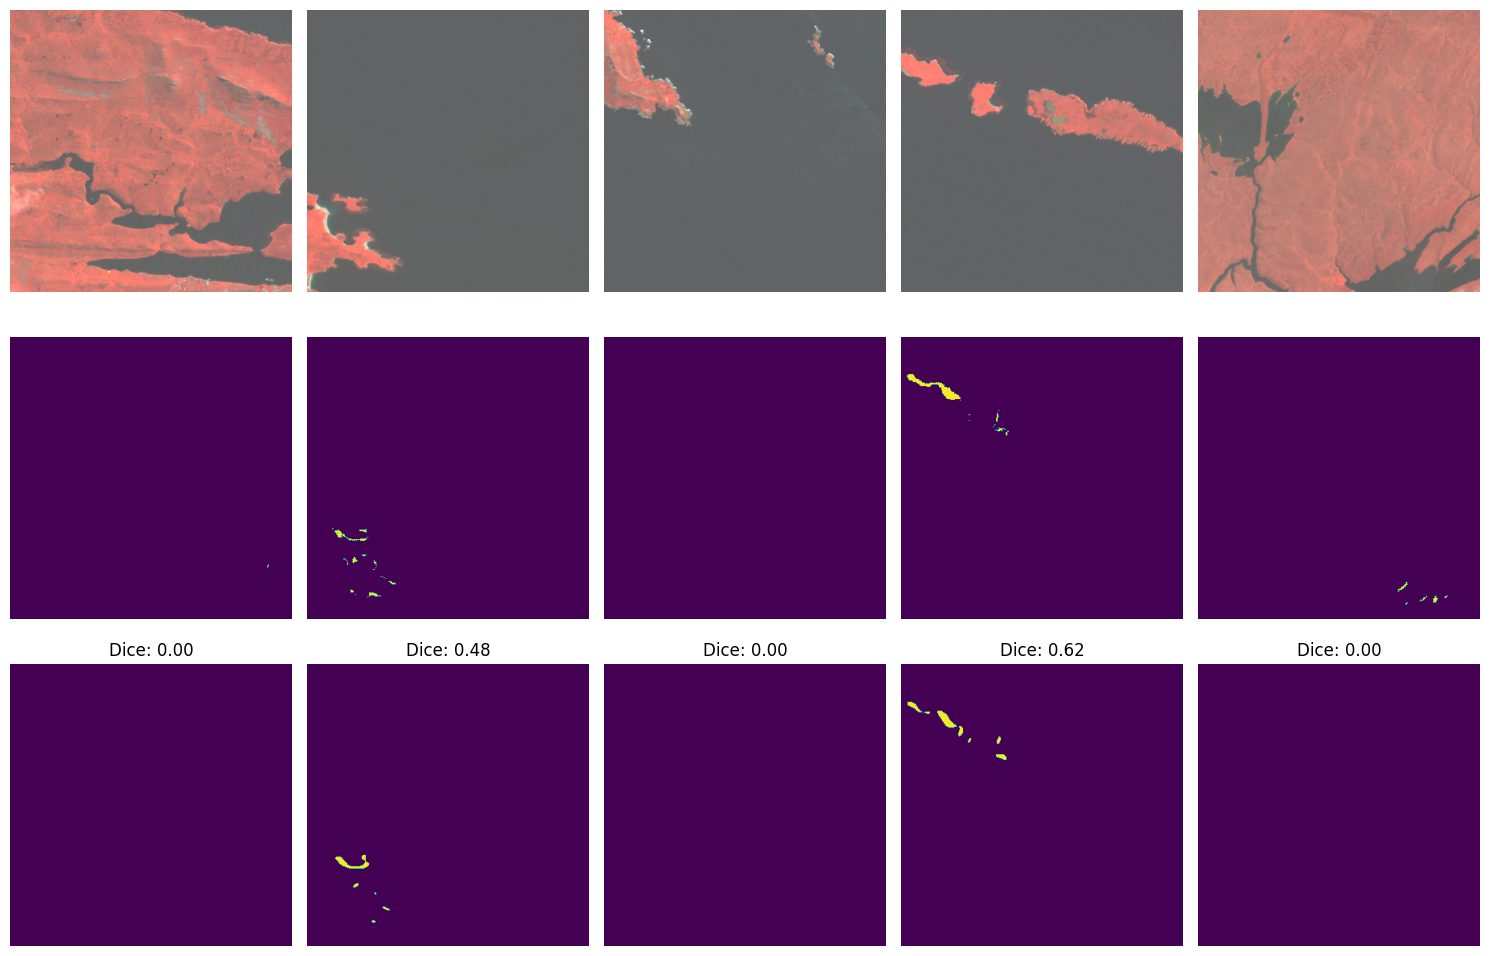

In [33]:
cols, rows = 5, 3  
batch = next(iter(dm.val_dataloader(shuffle=True)))
module.cuda()
module.eval()
with torch.no_grad():
	x, y = batch
	y_hat = module(x.cuda())
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  
metric = torchmetrics.Dice().cuda()
for col in range(cols):  
	ax = plt.subplot(rows, cols, col + 1) 
	ax.imshow(x[col][...,:3])
	ax.axis('off')
	ax = plt.subplot(rows, cols, col + 1 + cols)  
	ax.imshow(y[col])
	ax.axis('off')
	ax = plt.subplot(rows, cols, col + 1 + cols*2)  
	ax.imshow(torch.sigmoid(y_hat[col][0].cpu()) > 0.5)
	ax.axis('off')
	dice = metric(y_hat[col], y[col].cuda().unsqueeze(0))
	ax.set_title(f'Dice: {dice.item():.2f}')
plt.tight_layout()
plt.show()